In [3]:
import os
import sys

import numpy as np
import pandas as pd

sys.path.append(os.path.abspath("./evaluation"))

from EvalRSRunner import ChallengeDataset
from EvalRSReclist import EvalRSReclist
from gensim.models import KeyedVectors
from reclist.reclist import LOGGER, METADATA_STORE


Download [predictions](https://drive.google.com/file/d/19Ea1UkosnpIbWdWG4_L7yLj-53egtNrP/view?usp=sharing) from pre-trained model and put them in this repo.

In [4]:
DATA_PATH = 'evalrs23_model_predictions/'

In [5]:
events_train_df = pd.read_parquet(os.path.join(DATA_PATH, "events_train.parquet"))
events_test_df = pd.read_parquet(os.path.join(DATA_PATH, "events_test.parquet"))
preds_df = pd.read_parquet(
    os.path.join(DATA_PATH, "model_predictions/mf_test_preds.parquet")
)

In [6]:
dataset = ChallengeDataset(
    force_download=False,
    folded_dataset_split=False,
    sample_users_perc=0.25,
    min_user_item_freq=10,
)

LFM dataset already downloaded. Skipping download.
Loading dataset.
Generating dataset hashes.


In [7]:
dataset._train_set = events_train_df
dataset._test_set = events_test_df

In [8]:
similarity_model = KeyedVectors.load(
    os.path.join(dataset.path_to_dataset, "song2vec.wv")
)

Running RecTests ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:33

                                    EvalRSReclist                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                           Type ┃ Description  ┃                             Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                          stats │              │                                  { │
│                                │              │                "num_users": 29722, │
│                                │              │                    "max_items": 1, │
│                                │              │                     "min_items": 1 │
│                                │              │                                  } │
│                       HIT_RATE │              │                             0.0484 │
│ HIT_RATE_PERSONALIZED_K_MEDIAN │              │                             0.0003 │
│    HIT_RATE_PERSONALIZED_K_p99 │              │                             0.0003 │
│                            MRR │              │                             0.0023 │
│      MRR_PERSONALIZED_K_MEDIAN │              │                                0.0 │
│         MRR_PERSONALIZED_K_p99 │              │                                0.0 │
│                   MRED_COUNTRY │              │                                  { │
│                                │              │     "mred": -0.008300676473591426, │
│                                │              │          "mr": 0.9505530006461176, │
│                                │              │          "BR": 0.9394871794871795, │
│                                │              │          "CA": 0.9703703703703703, │
│                                │              │          "DE": 0.9561324977618622, │
│                                │              │          "ES": 0.9207317073170732, │
│                                │              │          "FI": 0.9569620253164557, │
│                                │              │           "FR": 0.946969696969697, │
│                                │              │          "NL": 0.9591280653950953, │
│                                │              │          "NaN": 0.949115321872255, │
│                                │              │          "PL": 0.9506398537477148, │
│                                │              │          "RU": 0.9526813880126183, │
│                                │              │          "SE": 0.9547038327526133, │
│                                │              │                        "UA": 0.94, │
│                                │              │          "UK": 0.9555160142348754, │
│                                │              │           "US": 0.9585913312693498 │
│                                │              │                                  } │
│             MRED_USER_ACTIVITY │              │                                  { │
│                                │              │     "mred": -0.018456655729888676, │
│                                │              │          "mr": 0.9515846847453066, │
│                                │              │           "1": 0.9050661798265632, │
│                                │              │         "100": 0.9549700085689803, │
│                                │              │         "1000": 0.9570508231925555 │
│                                │              │                                  } │
│          MRED_TRACK_POPULARITY │              │                                  { │
│                                │              │      "mred": -0.01845813801658494, │
│                                │              │          "mr": 0.9515846847453066, │
│                                │              │                          "1": 1.0, │
│                                │              │          "10": 0.9542479699430372, │
│                                │              │         "100": 0.9449300699300699, 

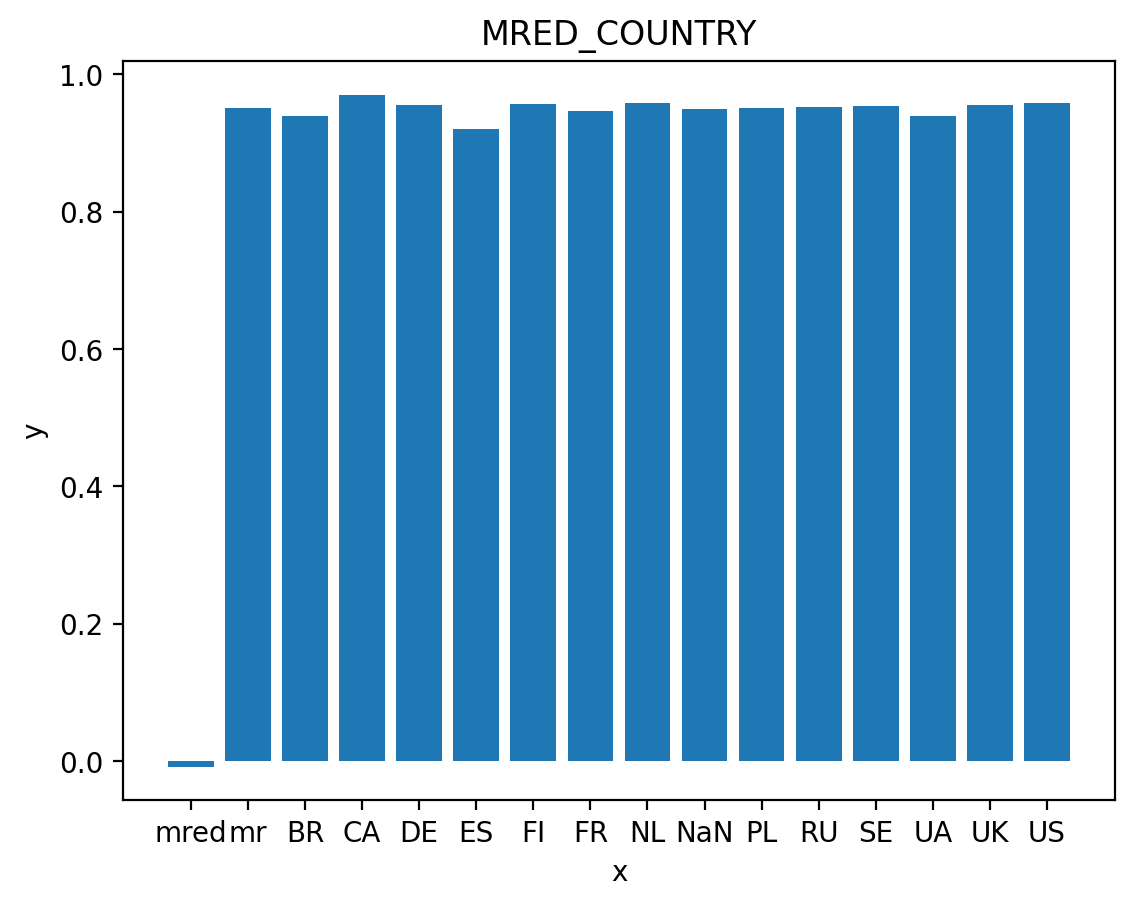

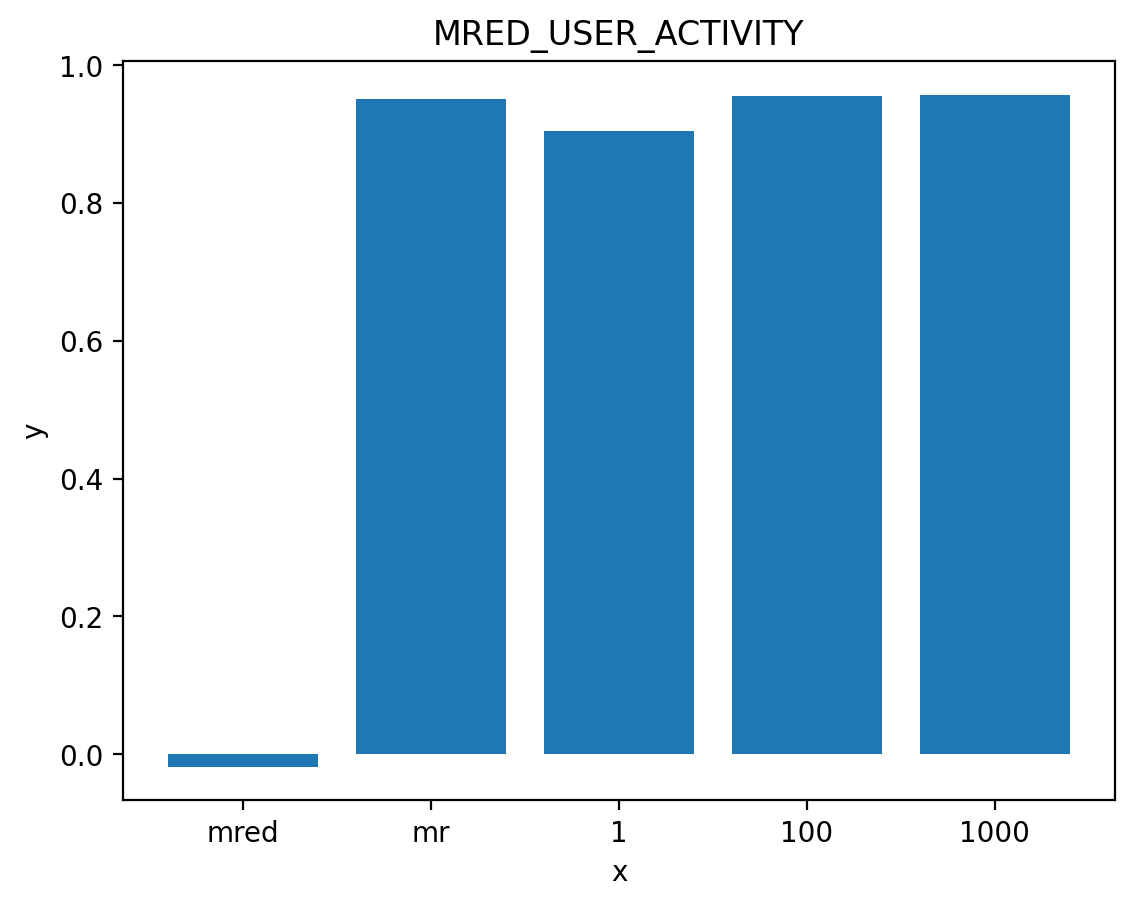

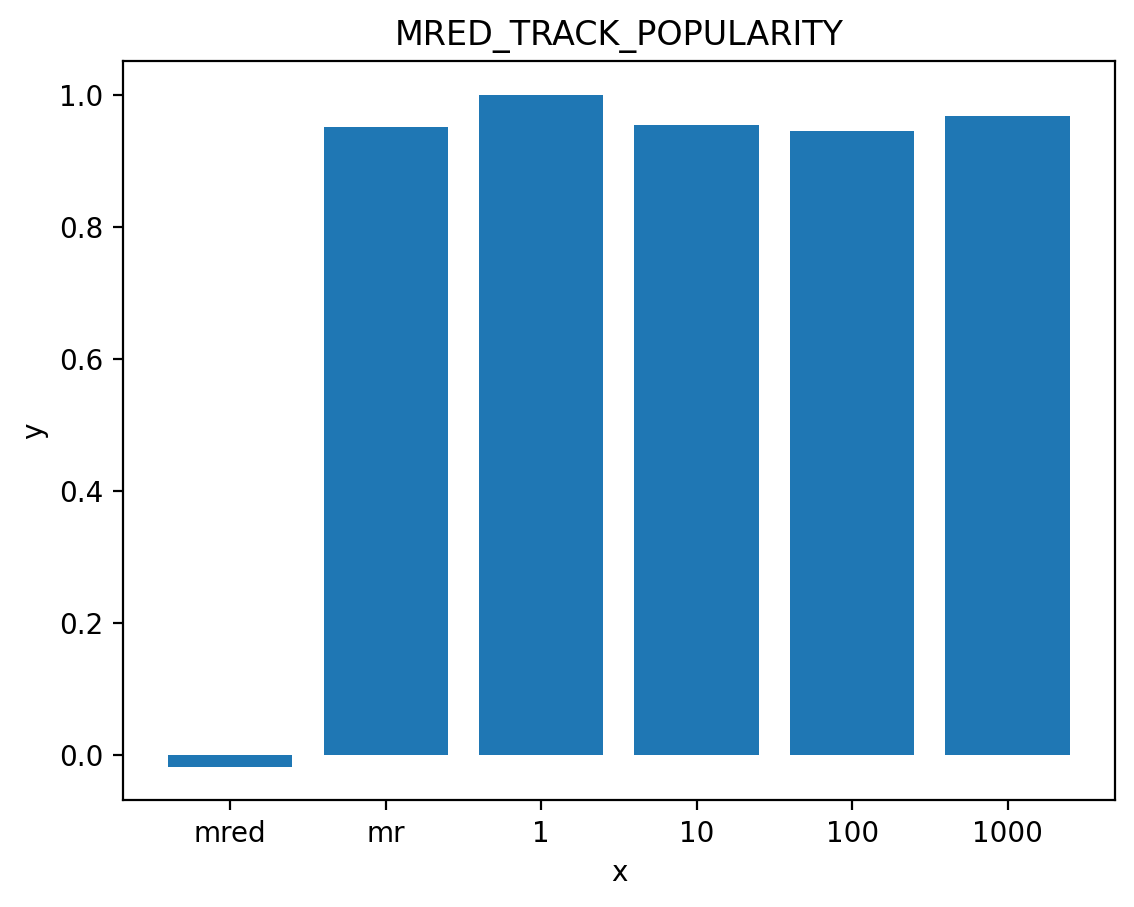

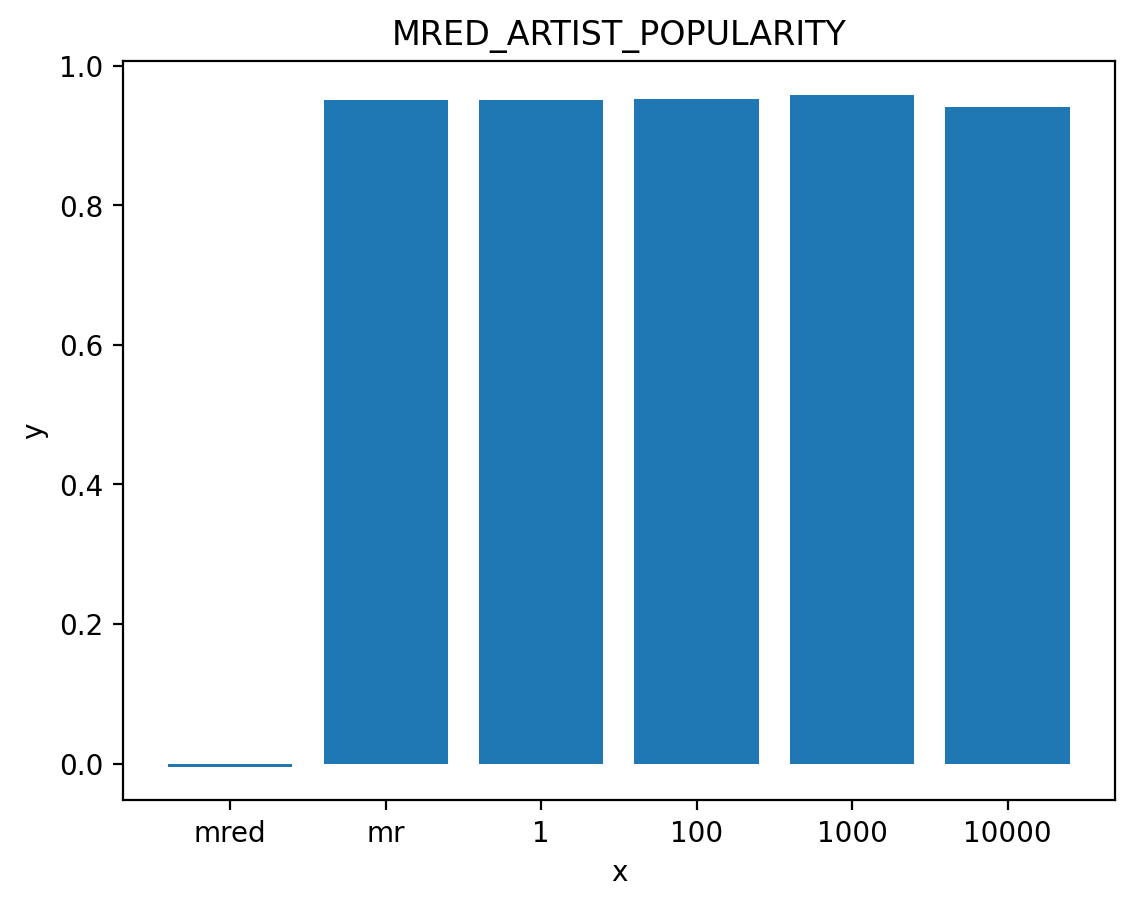

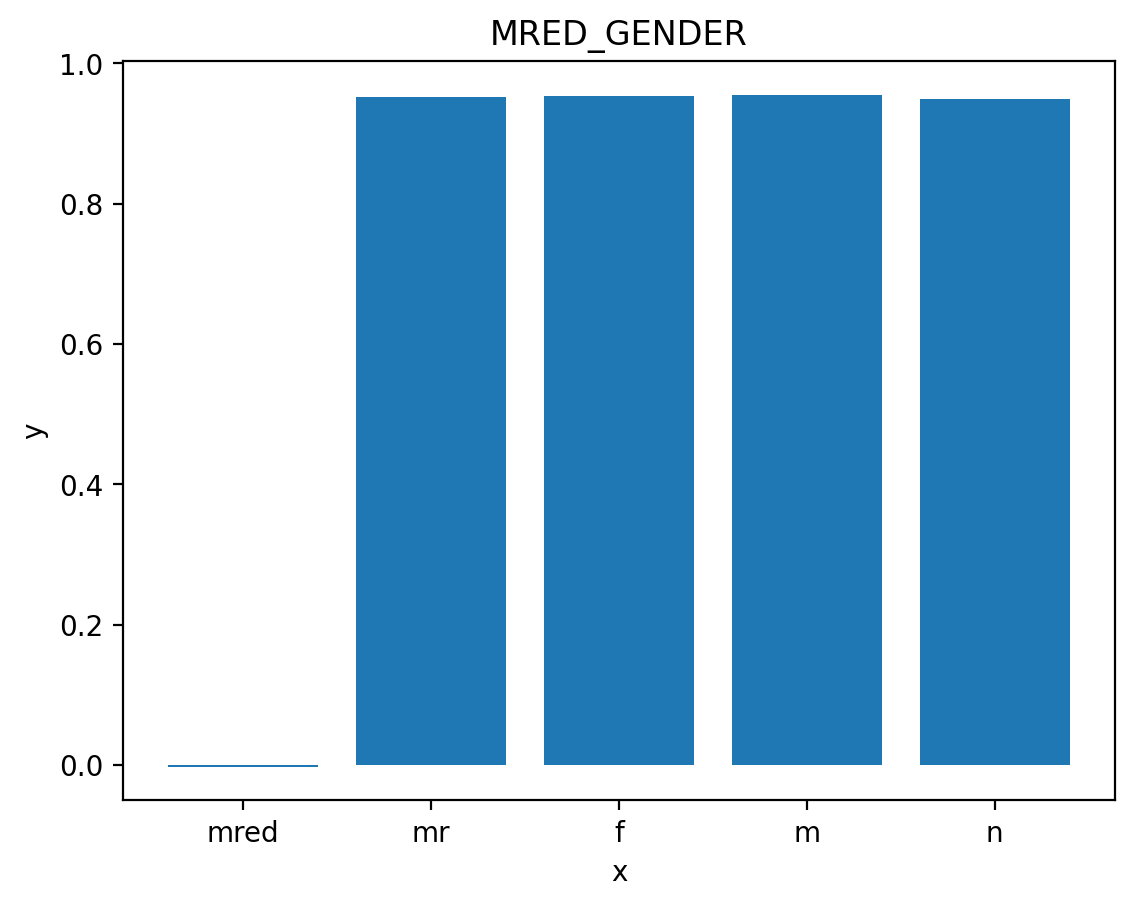

In [9]:
cdf = EvalRSReclist(
    dataset=dataset,
    model_name="PreTrainedModel",
    predictions=preds_df,
    logger=LOGGER.LOCAL,
    metadata_store=METADATA_STORE.LOCAL,
    similarity_model=similarity_model,
)

cdf(verbose=True)

In [2]:
def get_masked_preds(preds, data, q=0.5):
    df = preds.copy()
    data = data.copy()
    data.loc[:, "date"] = pd.to_datetime(data["timestamp"], unit="s").dt.date
    user_to_listens = dict(
        data.groupby(["user_id", "date"])["user_track_count"]
        .count()
        .reset_index()
        .groupby("user_id")["user_track_count"]
        .quantile(0.5)
    )
    df_list = df.apply(lambda x: list(x), axis=1)
    df_list = df_list.reset_index().apply(
        lambda x: [
            item for i, item in enumerate(x[0]) if i < user_to_listens[x["user_id"]]
        ],
        axis=1,
    )
    df_masked = pd.DataFrame(df_list.to_list(), index=preds.index).fillna(-1)
    df_masked.index.name = "user_id"
    return df_masked

In [ ]:
get_masked_preds(preds_df, events_train_df)

In [13]:
events_train_df.loc[:, "date"] = pd.to_datetime(events_train_df["timestamp"], unit="s").dt.date
events_train_df.groupby(["user_id", "date"])["user_track_count"].count().reset_index().groupby("user_id").median().describe()

,user_id,date,user_track_count
0,384,2013-12-29,2
1,384,2013-12-30,9
2,384,2013-12-31,14
3,384,2014-01-02,4
4,384,2014-01-04,9
...,...,...,...
1119239,50967444,2014-08-28,10
1119240,50967444,2014-08-29,18
1119241,50967444,2014-08-30,2
1119242,50967444,2014-08-31,24
